In [47]:
import numpy as np
from centrex_TlF_hamiltonian import states, hamiltonian
import matplotlib.pyplot as plt

In [48]:
qn_select = states.QuantumSelector(J=1, electronic=states.ElectronicState.X)
ground_states = states.generate_coupled_states_X(qn_select)
ground_states, H_X = hamiltonian.generate_reduced_X_hamiltonian(ground_states, Jmin = 0, Jmax = 3)

In [51]:
qn_select = states.QuantumSelector(J=1, F=0, F1=1/2, electronic=states.ElectronicState.B, P=+1, Ω=1)
excited_states = states.generate_coupled_states_B(qn_select)
excited_states, H_B = hamiltonian.generate_reduced_X_hamiltonian(excited_states, Jmin = 0, Jmax = 3)

In [52]:
energies_ground = (np.diag(H_X) - H_X[0,0]).real / (2*np.pi)

In [53]:
energies_excited = (np.diag(H_B) - H_B[0,0]).real / (2*np.pi)

In [62]:
def group_sublevels(energies, atol=5e3):
    atol = 5e3 # 5 kHz 
    indices = []
    for energy in energies:
        indices.append(tuple(np.where(np.isclose(energy, energies, atol = atol))[0]))
    indices = set(indices)
    return indices

In [150]:
indices_ground = group_sublevels(energies_ground)
indices_excited = group_sublevels(energies_excited)
indices_ground_involved = [1,3,4,6]

In [345]:
def plot_levels(
    indices, energies, states_array, indices_involved = None,
    ax = None, energy_scaling = 1e3, color = 'k', 
    x_offset = None, y_offset = None, 
    lw = 5
):
    if ax is None:
        fig, _ax = plt.subplots(figsize = (8,5))
    else:
        _ax = ax
    _y_offset = 0 if y_offset is None else y_offset
    _x_offset = 0 if x_offset is None else x_offset
        
    for inds in indices:
        for idx in inds:
            state = states_array[idx].largest
            mF = state.mF
            if indices_involved is not None:
                alpha = 1.0 if idx in indices_involved else 0.5
            else:
                alpha = 1.0
            _ax.hlines(
                energies[idx]/energy_scaling + _y_offset/energy_scaling, 
                mF-0.25 + _x_offset, mF+0.25 + _x_offset, 
                colors = color, linestyles = '-', lw = lw,
                alpha = alpha
            )
    if ax is None:
        return fig, _ax

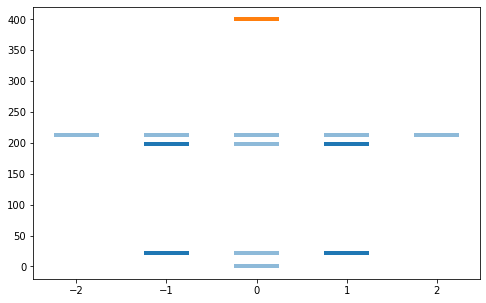

In [346]:
fig, ax = plot_levels(
    indices_ground, energies_ground, ground_states, indices_involved = indices_ground_involved,
    lw = 4, color = 'C0'
)
plot_levels(indices_excited, energies_excited, excited_states, ax = ax, color = 'C1', y_offset = 400e3, lw = 4)

In [347]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class CouplingArrow:
    index_ground: int
    index_excited: int
    x: float
    y: float
    dx: float
    dy: float
    yscaling: float
    start_offset: float
    head_offset: float
    color: str
    head_width: Optional[float] = None
    head_length: Optional[float] = None
    lw: float = 3
    
    def draw(self, ax):
        x,y = self.x, self.y
        dx, dy = self.dx, self.dy
        y /= self.yscaling
        dy /= self.yscaling
        y += self.start_offset/self.yscaling
        dy -= (self.start_offset + self.head_offset)/self.yscaling
        ax.arrow(
            x,y,dx,dy, 
            length_includes_head = True, head_width = self.head_width, head_length = self.head_length,
            color = self.color, lw = self.lw
        )
        
    @property
    def vector(self):
        return np.array([self.dx, self.dy])

In [348]:
def sort_xy(x, y):
    x0 = np.mean(x)
    y0 = np.mean(y)
    
    r = np.sqrt((x-x0)**2 + (y-y0)**2)
    
    # angles = np.arctan2(y-y0, x-x0)
    # angles = np.arctan2(x-x0, y-y0)
    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)
    
    indices_pi2 = np.where(angles < np.pi/2)[0]
    order = np.argsort(angles[indices_pi2])[::-1]
    indices_pi2 = indices_pi2[order]
    
    for idx in indices_pi2:
        mask  = np.delete(mask, np.where(mask == idx)[0])
    mask = np.append(mask, indices_pi2)

    # x_sorted = x[mask]
    # y_sorted = y[mask]

    return mask

In [349]:
def get_angle(vec1, vec2):
    return np.arccos(vec1@vec2 / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

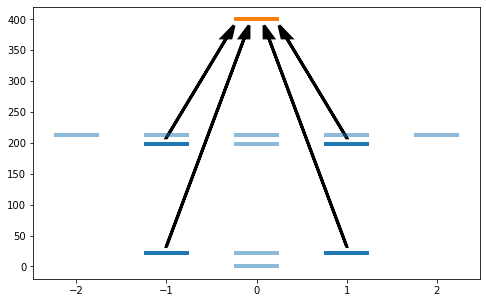

In [362]:
couplings = [(1,0),(4,0),(3,0),(6,0)]
y_offset = 400e3
x_offset = 0
arrow_width = 3
head_width = 0.1
head_length = 20
energy_scaling = 1e3
head_offset = 10e3
start_offset = 10e3
arrow_color = 'k'

fig, ax = plot_levels(
    indices_ground, energies_ground, ground_states, indices_involved = indices_ground_involved,
    lw = 4, color = 'C0'
)
plot_levels(
    indices_excited, energies_excited, excited_states, ax = ax, color = 'C1', 
    x_offset = x_offset, y_offset = y_offset, lw = 4)

arrows = []

for idg,ide in couplings:
    gs = ground_states[idg].largest
    es = excited_states[ide].largest
    mFg, mFe = gs.mF, es.mF
    x,y = mFg, energies_ground[idg]
    dx = mFe-mFg + x_offset
    dy = energies_excited[ide] + offset - y
    
    arrows.append(
        CouplingArrow(
            idg,ide,x,y,dx,dy,energy_scaling,
            start_offset,head_offset,arrow_color,
            head_width,head_length)
    )
    
indices, counts = np.unique([arrow.index_excited for arrow in arrows], return_counts = True)
arrows_per_level = {idx:c for idx,c in zip(indices, counts)}
arrows_plotted_per_level = {idx:0 for idx in arrows_per_level.keys()}

mask = np.argsort([get_angle(arrow.vector, np.array([1.0, 0])) for arrow in arrows])

for arrow in np.asarray(arrows)[mask]:
    ide = arrow.index_excited
    nr_level = arrows_per_level[ide]
    if nr_level > 1:
        dx = 0.5/(nr_level-1)
        arrow.dx += -(0.5/2) + dx*arrows_plotted_per_level[ide]
        arrow.draw(ax)
        arrows_plotted_per_level[ide] += 1

In [ ]:
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.patches as mpatches

def curly_arrow(start, end, arr_size = 1, n = 5, col='gray', linew=1., width = 0.1):
    xmin, ymin = start
    xmax, ymax = end
    dist = np.sqrt((xmin - xmax)**2 + (ymin - ymax)**2)
    n0 = dist / (2 * np.pi)
    
    x = np.linspace(0, dist, 151) + xmin
    y = width * np.sin(n * x / n0) + ymin
    line = plt.Line2D(x,y, color=col, lw=linew)
    
    del_x = xmax - xmin
    del_y = ymax - ymin
    ang = np.arctan2(del_y, del_x)
    
    line.set_transform(mpl.transforms.Affine2D().rotate_around(xmin, ymin, ang) + ax.transData)
    ax.add_line(line)

    verts = np.array([[0,1],[0,-1],[2,0],[0,1]]).astype(float) * arr_size
    verts[:,1] += ymax
    verts[:,0] += xmax
    path = mpath.Path(verts)
    patch = mpatches.PathPatch(path, fc=col, ec=col)

    patch.set_transform(mpl.transforms.Affine2D().rotate_around(xmax, ymax, ang) + ax.transData)
    return patch